# Twitter trolls exploratory analysis

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import dask.dataframe as dd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from IPython.display import display

In [5]:
sns.set_style('white')
pd.set_option('display.float_format', "{:.3f}".format)
plt.rcParams['figure.figsize'] = 12,8

DATA_FILE = "../data/english.csv"
URL_RGX = r"((http|ftp|https):\/\/)?([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:\/~+#-]*[\w@?^=%&\/~+#-])?"

In [3]:
def load_dask(fn):
    # 3261930 rows
    # Using dask for multithread support
    df = dd.read_csv(fn, dtype='object')
    df = df.repartition(npartitions=128)
    print(f'{len(df.index)} rows x {len(df.columns)} cols')
    return df

def load_sample(fn, nrows):
    df = pd.read_csv(fn, nrows=nrows)
    print('{} rows x {} cols'.format(*df.shape))
    return df

def load_data(fn, sample=True, size=1000):
    t0 = time()
    df = load_sample(fn, size) if sample else load_dask(DATA_FILE)
    print(f'Loaded in {time() - t0:.2f}s'); t0 = time()
    df = clean(df)
    print(f'')
    return df
    
def clean(df):
    df["tweet_time"] = dd.to_datetime(df["tweet_time"], format="%Y-%m-%d %H:%M")
    df["tweet_text"] = df["tweet_text"].str.replace(URL_RGX, "%URL%")
    return (df.set_index('tweet_time')
#            .drop(["longitude", "latitude", "tweet_language", "poll_choices", "urls"], axis=1)
    )

In [6]:
df = load_data(DATA_FILE, sample=True, size=1000)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 0: invalid start byte

### Missing values

 - Lots of missing values here. 
 - Unfortunately, latitude and longitude are not usable, nor are poll choices, whatever it means. 
 - Might be interesting to dig into user_reported_location. 
 - Most user profile url are missing as well, for some reason. Urls are mostly there. Maybe some crawling to do if necessary.
 - The remaining columns with missing values (in_reply, quoted_tweet, retweet, user_mentions, hashtags) probably indicate False when the value is missing.

In [20]:
# Just check what is actually usable here and what we need to drop
df.isnull().mean(axis=0).sort_values(ascending=False).map("{:.2%}".format).rename('missing values')

longitude                   100.00%
latitude                    100.00%
poll_choices                 99.99%
in_reply_to_tweetid          98.04%
in_reply_to_userid           97.02%
quoted_tweet_tweetid         96.03%
user_profile_url             82.44%
retweet_userid               66.90%
retweet_tweetid              66.90%
user_mentions                60.57%
urls                         13.86%
user_profile_description     11.16%
user_reported_location       10.11%
hashtags                      9.18%
quote_count                   0.04%
reply_count                   0.04%
like_count                    0.04%
retweet_count                 0.04%
tweet_client_name             0.00%
userid                        0.00%
user_display_name             0.00%
user_screen_name              0.00%
tweet_text                    0.00%
follower_count                0.00%
following_count               0.00%
account_creation_date         0.00%
account_language              0.00%
tweet_language              

### Tweet timing

,Daily,Weekly,Monthly,Business Days
count,1819.000,261.000,120.000,1301.000
mean,27.488,191.571,416.667,38.432
std,34.491,193.915,393.459,51.127
min,0.000,0.000,0.000,0.000
25%,0.000,3.000,7.500,0.000
50%,19.000,178.000,420.500,26.000
75%,41.000,301.000,625.250,55.000
max,389.000,1061.000,1797.000,496.000


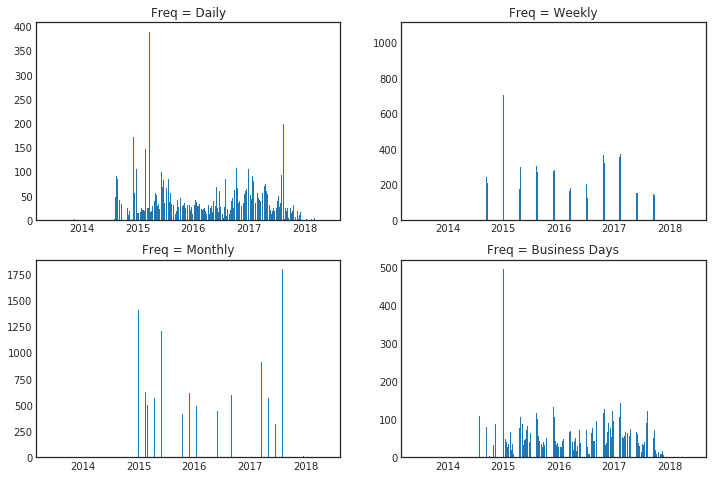

In [21]:
# Resample on frequency and plot the histogram

frequencies = ["Daily", "Weekly", "Monthly", "Business Days"]

fig, axs = plt.subplots(2,2)
summary = pd.DataFrame()
for ax, freq in zip([ax for axr in axs for ax in axr], frequencies):
    sampling = freq[0] if freq[0] != 'M' else 'SM'
    df_freq = df[['tweetid']].resample(sampling).count()  #.compute()
    ax.bar(df_freq.index, df_freq.tweetid)
    ax.set_title(f"Freq = {freq}");
    descr = df_freq.describe()
    summary[freq] = descr.values[:, 0]
summary.set_index(descr.index, inplace=True)

display(summary)
plt.savefig("images/timeline.png")

### Users

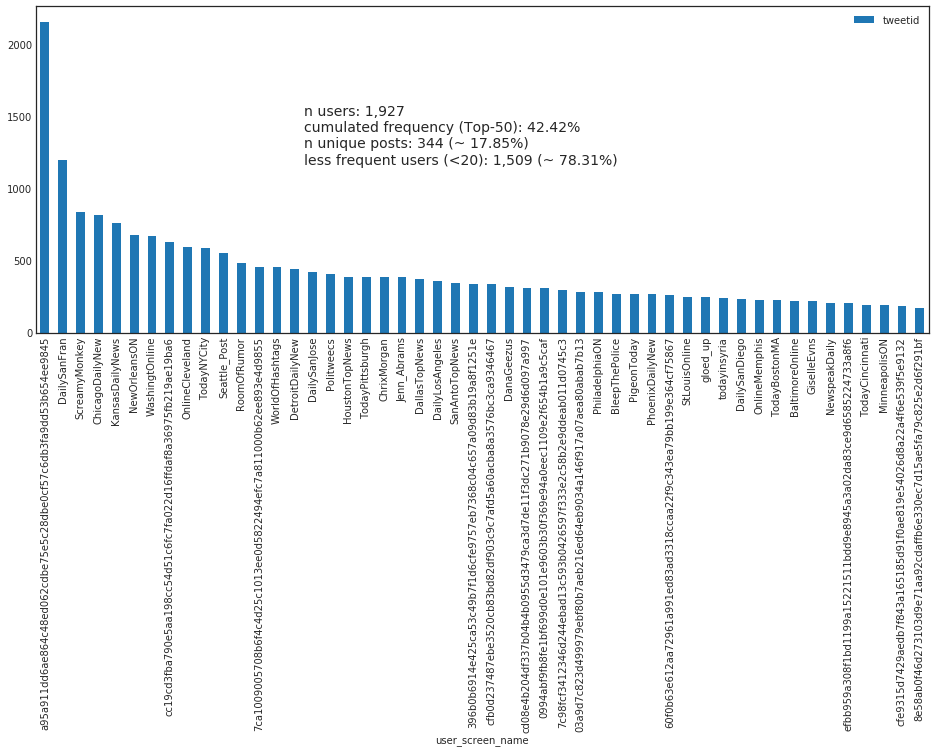

In [32]:
def histogram_summary(ax, x, y, summary):
    textbox = "\n".join([": ".join([k, v]) for k, v in summary.items()])
    ax.text(.3, .7, textbox,
            horizontalalignment='left',
            verticalalignment='top',
            transform=ax.transAxes,
            fontsize=14);
    ax.get_figure().set_size_inches((16, 6))

counts_by_users = (df[["user_screen_name", "tweetid"]]
                   .groupby("user_screen_name")
                   .count()
                   .sort_values("tweetid", ascending=False))

k, thres = 50, 20
nunique_posts = len(counts_by_users.loc[counts_by_users["tweetid"] <= 1])
less_frequent = len(counts_by_users.loc[counts_by_users["tweetid"] <= thres])
top_users = counts_by_users.head(k)
ax = top_users.plot.bar()

histogram_summary(ax, .6, .7, {
    "n users": f"{len(counts_by_users):,}",
    f'cumulated frequency (Top-{k})': f"{(top_users.sum() / counts_by_users.sum()).values[0]:.2%}",
    f"n unique posts": f"{nunique_posts:,} (~ {nunique_posts / len(counts_by_users):.2%})",
    f"less frequent users (<{thres})": f"{less_frequent:,} (~ {less_frequent / len(counts_by_users):.2%})"
    
})

## Tweet text

In [4]:
# Whole dataset
data = load_data(DATA_FILE, sample=False)
X = data['tweet_text'].values.compute()

3261931 rows x 31 cols
Loaded in 30.32s



In [5]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.pipeline import Pipeline

### Count Vectorizer

<div style="color: red">Text Instance (m x 1) --> Word Counts (m x n), n = size of vocabulary</div>

In [6]:
vect = CountVectorizer()
X_vect = vect.fit_transform(X)

In [13]:
def prep_frequency(matrix, aggfunc):
    return (
        pd.DataFrame(aggfunc(X_vect, axis=0).T, 
                     index=vect.get_feature_names(), 
                     columns=["count"])
        .sort_values("count", ascending=False))

def frequency_histogram(matrix, k=50, thres=100, aggfunc=np.sum):
    cnts = prep_frequency(matrix, aggfunc)
    n = len(cnts)
    sel = cnts.iloc[:k, :]
    ax = sel.plot.bar()
    nunique_words = (cnts["count"] <= 1).sum()
    less_frequent = (cnts["count"] < thres).sum()
    ax.set_title(f"Top-{k}", fontsize=18)
    summary = {
        'size of vocabulary': f"{n:,}",
        f'cumulated frequency (Top-{k})': f"{(sel.sum() / cnts.sum()).values[0]:.2%}",
        f"n unique words": f"{nunique_words:,} (~ {nunique_words / n:.2%})",
        f"less frequent words (<{thres})": f"{less_frequent:,} (~ {less_frequent / n:.2%})"
    }
    histogram_summary(ax, .3, .7, summary)
    return cnts

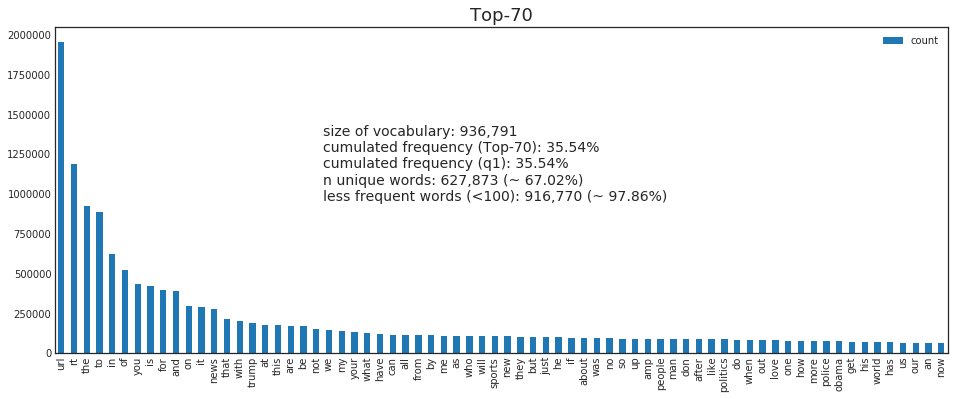

In [14]:
cnts = frequency_histogram(X_vect, 70)

Select only 10,000 most frequent words

In [36]:
n_to_keep = 10000
to_keep = list(cnts.iloc[:n_to_keep, :].index)
[v for k, v in vect.vocabulary_.items() if k in to_keep]
X_top10k = X[[v for k, v in vect.vocabulary_.items() if k in to_keep]]
# len(X_top10k)

Text(0.5,1,'Distribution of word frquency')

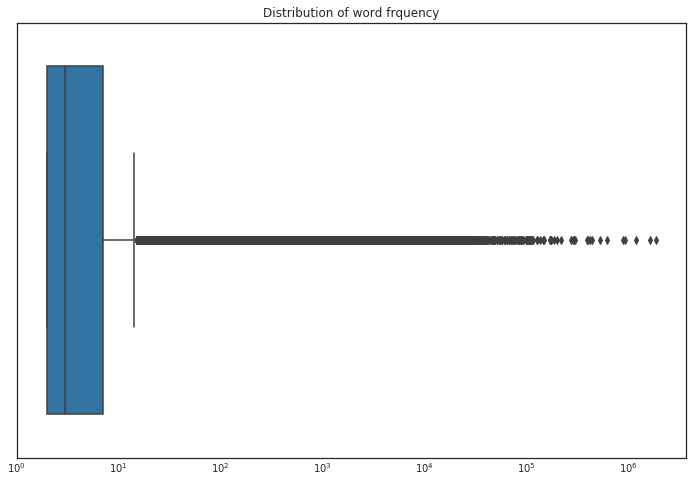

In [62]:
# sns.boxplot(cnts[cnts["count"] > 1])
# plt.gca().set_xscale('log')
# plt.title("Distribution of word frquency")
# cnts.loc[cnts["count"] > 1, "count"].apply(np.log10).plot.hist();

### Tf-Idf Vectorizer

<div style="color: red">Same distribution as for the count vectorizer but might give better results for classification purposes</div>

In [44]:
# tfidf = TfidfVectorizer()
# X_tfidf = tfidf.fit_transform(X)
# frequency_histogram(X_tfidf, thres=1e-4, aggfunc=np.mean);

### Single Value Decomposition

<div style="color: red">Useless at the moment, I was trying to find some nice visualisation proving that features might be (linearly) separable but no luck there at the moment...</div>

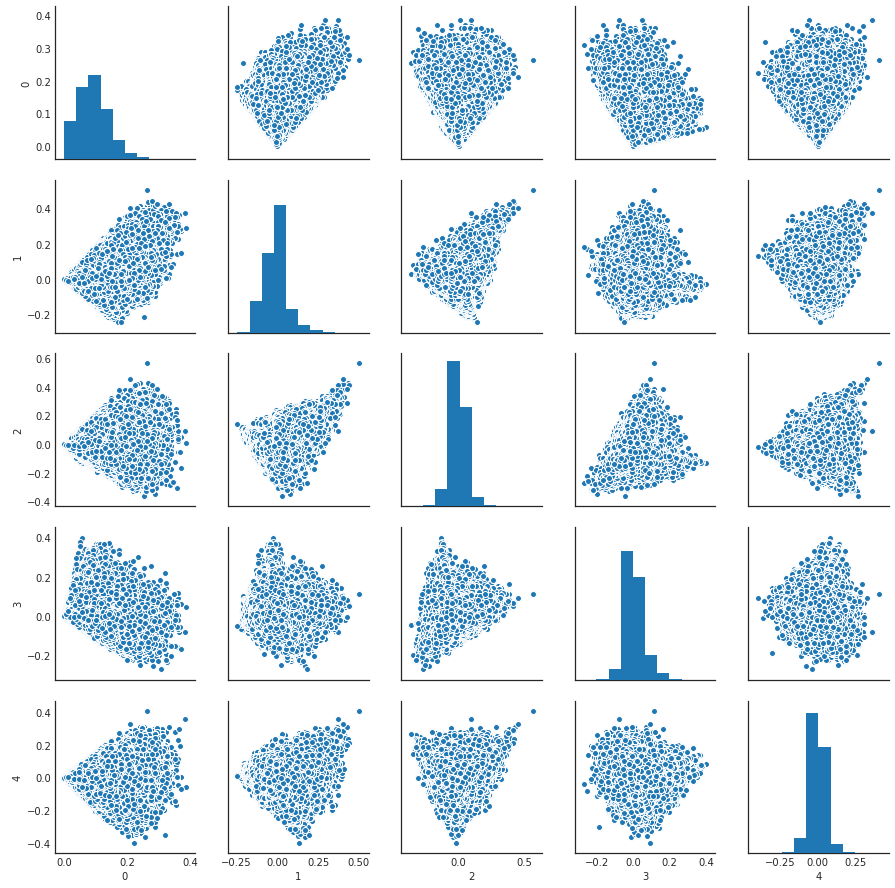

In [61]:
# svd = TruncatedSVD(n_components=5)
# X_svd = svd.fit_transform(X_tfidf)
# sns.pairplot(pd.DataFrame(X_svd));

## Pipeline


<div style="color: red">Chaining operations all together</div>

In [21]:
preprocessor = Pipeline([
    ('vect', CountVectorizer()),
     ('tfidf', TfidfTransformer()),
    ('svd', TruncatedSVD(n_components=5)),
    ('cluster', KMeans(n_clusters=8)),
#     ('clf', SVC())
])

In [23]:
# X_vect = preprocessor.fit_transform(X)
# X_idf = preprocessor.fit_transform(X)
# X_svd = preprocessor.fit_transform(X)
X_cluster = preprocessor.fit_transform(X)

In [24]:
vect = preprocessor.named_steps['vect']
# tfidf = preprocessor.named_steps['tfidf']

## Grid Search

In [ ]:
params_grid = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'tfidf__use_idf': (True, False),
    'pca__n_components': [2, 5, 8],
#     'clf__alpha': (1e-2, 1e-3),
}

